In [1]:
!pip install pyodbc
import warnings
import os
import pyodbc as odbc
import pandas as  pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf



In [2]:
server="(LocalDb)\canzo"
db='canzo1'
tcon='yes'
uname="DESKTOP-UVHA1I6\LOCALDB#2A4D1D5A"

db=odbc.connect(driver='{SQL Server Native Client 11.0}', host=server, database=db, UID=uname ,
                      trusted_connection=tcon)
cursor=db.cursor()

In [3]:
def found_sales_in(Ay,Yıl,sid,operation_code,*args):
    if operation_code==1 :
        satışçı_id=sid
        query='SELECT Satisci_id , COUNT(Satisci_id) AS satış_sayısı FROM Booking b WHERE MONTH(islemTarih)=%d and YEAR(islemTarih)=%d and Satisci_id=%d GROUP BY Satisci_id' %(Ay,Yıl,satışçı_id)
        data=pd.read_sql(query, db)
        data=data.set_index("Satisci_id")
        if len(data)==0:
            x=0
        else : 
            x=data.iloc[0]["satış_sayısı"]
        return x
    
    elif operation_code==2 :
        satışçı_id=sid
        consignee_id=args[0]
        query='SELECT Satisci_id , COUNT(Satisci_id) AS satış_sayısı FROM Booking b WHERE MONTH(islemTarih)=%d and YEAR(islemTarih)=%d and Satisci_id=%d and Consignee_id=%d GROUP BY Satisci_id' %(Ay,Yıl,satışçı_id,consignee_id)
        data=pd.read_sql(query, db)
        data=data.set_index("Satisci_id")
        if len(data)==0 :
            x=0
        else : 
            x=data.iloc[0]["satış_sayısı"]
        return x
                
    elif operation_code==3 :
        satışçı_id=sid
        pod_id=args[0]
        query='SELECT Satisci_id , COUNT(Satisci_id) AS satış_sayısı FROM Booking b WHERE MONTH(islemTarih)=%d and YEAR(islemTarih)=%d and  Satisci_id=%d and Pod_id=%d GROUP BY Satisci_id' %(Ay,Yıl,satışçı_id,pod_id)
        data=pd.read_sql(query, db)
        data=data.set_index("Satisci_id")
        if len(data)==0 :
            x=0
        else : 
            x=data.iloc[0]["satış_sayısı"]
                
        return x
    else :
        sys.exit("Too many arguments has been entered or wrong argument name has been entered")

In [4]:
def date_increase(Ay,Yıl):
    ay=Ay
    yıl=Yıl
    if ay>=12 :
        ay=1
        yıl=yıl+1
    else :
        ay=ay+1
    return ay , yıl

In [5]:
def All_sales_month_by_month():
    satışçı_id=int(input("please enter a satışçı id:  "))
    print("Enter 1: If you want to learn sales of salesman per month.\nEnter 2: If you want to learn sales of salesman to a specific consignee per month.\nEnter 3: If you want learn sales of a salesperson from specific pod per month.")
    operation_code=int(input("Enter operation code: "))
    
    if operation_code==1 :
            Columns=["satış_sayısı","Ay","Yıl"]
            sales_list =[]
            month_list =[]
            year_list =[]
            index_list=[]
            month=10
            year=2021
            for i in range(18):
                sales_list.append(found_sales_in(month,year,satışçı_id,operation_code))
                month_list.append(month)
                year_list.append(year)
                index_list.append(i)
                month,year=date_increase(month,year)
            Df_data=list(zip(sales_list,month_list,year_list))
            df_salesman=pd.DataFrame(data=Df_data,index=index_list ,columns=Columns )
            df_salesman['date'] = pd.to_datetime(dict(year=df_salesman.Yıl, month=df_salesman.Ay,day=1))
            df_salesman=df_salesman.drop(["Ay","Yıl"],axis=1)
            
            return df_salesman
            
    elif operation_code==2 :
            consignee_id=int(input("please enter a consignee id: "))
            Columns=["satış_sayısı","Ay","Yıl"]
            sales_list =[]
            month_list =[]
            year_list =[]
            index_list=[]
            month=10
            year=2021
            for i in range(18):
                sales_list.append(found_sales_in(month,year,satışçı_id,operation_code,consignee_id))
                month_list.append(month)
                year_list.append(year)
                index_list.append(i)
                month,year=date_increase(month,year)
                
            Df_data=list(zip(sales_list,month_list,year_list))
            df_salesman=pd.DataFrame(data=Df_data,index=index_list ,columns=Columns )
            df_salesman['date'] = pd.to_datetime(dict(year=df_salesman.Yıl, month=df_salesman.Ay,day=1))
            df_salesman=df_salesman.drop(["Ay","Yıl"],axis=1)
            return df_salesman
            
    elif operation_code==3 :
            pod_id=int(input("please enter a pod id: "))
            Columns=["satış_sayısı","Ay","Yıl"]
            sales_list =[]
            month_list =[]
            year_list =[]
            index_list=[]
            month=10
            year=2021
            for i in range(18):
                sales_list.append(found_sales_in(month,year,satışçı_id,operation_code,pod_id))
                month_list.append(month)
                year_list.append(year)
                index_list.append(i)
                month,year=date_increase(month,year)
            Df_data=list(zip(sales_list,month_list,year_list))
            df_salesman=pd.DataFrame(data=Df_data ,index=index_list,columns=Columns )
            df_salesman['date'] = pd.to_datetime(dict(year=df_salesman.Yıl, month=df_salesman.Ay,day=1))
            df_salesman=df_salesman.drop(["Ay","Yıl"],axis=1)
            return df_salesman
    else:
           sys.exit("The code has been entered is invalid")
        
            
      
           

In [6]:
def sales_forecast():
   
    warnings.filterwarnings("ignore")
    df1=All_sales_month_by_month()
    df1=df1.set_index("date")
    scaler_full_data = MinMaxScaler()
    normalized_data = scaler_full_data.fit_transform(df1)
    length=12
    
    ay_başlangıç=3
    yıl_başlangıç=2023
    ay_tahmin=int(input("Enter a month which you want to predict sales in : "))
    yıl_tahmin=int(input("Enter a year which you want to predict sales in : "))
    
    generator=TimeseriesGenerator(normalized_data,normalized_data,length=length,batch_size=1)
    model=Sequential()
   # model.add(LSTM(150, activation='relu',return_sequences=True, input_shape=(length, 1)))
    model.add(LSTM(100, activation='relu' ))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam() , loss='mse')
    model.fit_generator(generator , epochs=100)
    
    forecasts = []
    forecast_range=(ay_tahmin-ay_başlangıç)+12*(yıl_tahmin-yıl_başlangıç)
    first_batch = normalized_data[-length:]
    batch = first_batch.reshape((1, length, 1))

    for i in range(forecast_range):
    
        prediction = model.predict(batch)[0]
        forecasts.append(prediction) 
        batch = np.append(batch[:,1:,:],[[prediction]],axis=1)
    
    forecast_data = scaler_full_data.inverse_transform(forecasts)
    df_forecast = pd.DataFrame(data=forecast_data,columns=['Forecast'])
    forecast=df_forecast.iloc[forecast_range-1]["Forecast"]
    forecast=int(forecast)
    
    return df_forecast

In [9]:
query=" SELECT t.Satisci_id , satış_sayısı FROM(SELECT Satisci_id , COUNT(Satisci_id) as satış_sayısı FROM Booking WHERE MONTH(islemTarih)=3 and YEAR(islemTarih)=2023 GROUP BY Satisci_id) t WHERE t.satış_sayısı>=50"
df1=pd.read_sql(query, db)
df1
#[8,9,20,21,33]

,Satisci_id,satış_sayısı
0,8,172
1,9,100
2,14,52
3,16,75
4,19,70
5,20,158
6,21,142
7,33,77
8,71,69
9,168,52


In [8]:
warnings.filterwarnings("ignore")
query=" SELECT t.Satisci_id , satış_sayısı FROM(SELECT Satisci_id , COUNT(Satisci_id) as satış_sayısı FROM Booking WHERE MONTH(islemTarih)=3 and YEAR(islemTarih)=2023 GROUP BY Satisci_id) t WHERE t.satış_sayısı>=50"
df=pd.read_sql(query, db)
satışçı_list=list(df["Satisci_id"])
satış_list=[]

satış_sayısı=list(df["satış_sayısı"])
forecast_list=[]
for i in satışçı_list:
    forecast=sales_forecast()
    forecast_list.append(forecast)
df["forecast"]=forecast_list
df

#for i in satışçı_list:
    #satışçı_id=i
    #query1="SELECT Satisci_id , COUNT(Satisci_id) AS satış_sayısı FROM Booking b WHERE MONTH(islemTarih)=1 and YEAR(islemTarih)=2023 and Satisci_id=%d GROUP BY Satisci_id" %(satışçı_id)
    #df1=pd.read_sql(query1,db)
    #satış=int(df1.iloc[0]["satış_sayısı"])
    #satış_list.append(satış)
#df["satış_sayısı"]=satış_list
#df
    


please enter a satışçı id:  8
Enter 1: If you want to learn sales of salesman per month.
Enter 2: If you want to learn sales of salesman to a specific consignee per month.
Enter 3: If you want learn sales of a salesperson from specific pod per month.
Enter operation code: 1
Enter a month which you want to predict sales in : 4
Enter a year which you want to predict sales in : 2024
Epoch 1/100
6/6 [==============================] - 2s 12ms/step - loss: 0.2718
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2228
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1761
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1513
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1683
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1603
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1531
Epoch 8/100
6/6 [==============================] - 0s 12ms/step 

6/6 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 88/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 89/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 90/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 91/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 92/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0467
Epoch 93/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0497
Epoch 94/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0453
Epoch 95/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0532
Epoch 96/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0445
Epoch 97/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0480
Epoch 98/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0429
Epoch 99/100
6/6 [==============================] - 0s 12ms/st

KeyboardInterrupt: Interrupted by user

In [ ]:
query=" SELECT t.Satisci_id , satış_sayısı FROM(SELECT Satisci_id , COUNT(Satisci_id) as satış_sayısı FROM Booking WHERE MONTH(islemTarih)=2 and YEAR(islemTarih)=2023 GROUP BY Satisci_id) t WHERE t.satış_sayısı>=50"
df=pd.read_sql(query, db)
df

In [16]:
forecast_df=sales_forecast()



please enter a satışçı id:  9
Enter 1: If you want to learn sales of salesman per month.
Enter 2: If you want to learn sales of salesman to a specific consignee per month.
Enter 3: If you want learn sales of a salesperson from specific pod per month.
Enter operation code: 1
Enter a month which you want to predict sales in : 3
Enter a year which you want to predict sales in : 2024
Epoch 1/100
6/6 [==============================] - 3s 8ms/step - loss: 0.2188 
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1811
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1590
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1285
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1024
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1038
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1103
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - los

In [17]:
periods=len(forecast_df)
forecast_index = pd.date_range(start='2023-04-01',periods=periods,freq='MS')
forecasts=list(forecast_df["Forecast"])
df_forecast=pd.DataFrame(data=forecasts,index=forecast_index,columns=["Forecast"])
df_forecast

,Forecast
2023-04-01,90.304079
2023-05-01,95.874330
2023-06-01,103.329612
2023-07-01,107.385973
2023-08-01,117.752651
2023-09-01,131.267039
2023-10-01,141.834324
2023-11-01,149.068190
2023-12-01,140.691897
2024-01-01,74.483523


In [18]:
df=All_sales_month_by_month()
df=df.set_index("date")
df


please enter a satışçı id:  9
Enter 1: If you want to learn sales of salesman per month.
Enter 2: If you want to learn sales of salesman to a specific consignee per month.
Enter 3: If you want learn sales of a salesperson from specific pod per month.
Enter operation code: 1


,satış_sayısı
date,
2021-10-01,77
2021-11-01,125
2021-12-01,139
2022-01-01,114
2022-02-01,72
2022-03-01,61
2022-04-01,85
2022-05-01,78
2022-06-01,89


<Axes: xlabel='date'>

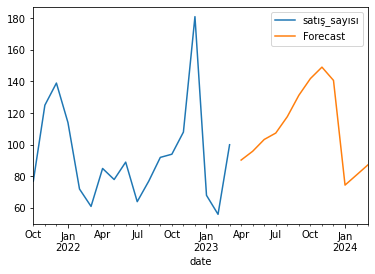

In [19]:
ax = df.plot()
df_forecast.plot(ax=ax)

In [ ]:
ax1=